# Image Augementation for 3D images

Powered by **Analytics Zoo/Spark** for deep learning, running on **Intel** architecture. In this demo, we will show some imaging processing methods on meniscus data.

In [1]:
import os
import numpy as np
import matplotlib
matplotlib.use('Agg')
%pylab inline
from matplotlib import pyplot as plt
import h5py
from math import pi

from zoo.common.nncontext import *
from zoo.feature.common import *
from zoo.feature.image3d.transformation import *

sc = init_nncontext("Image Augmentation 3D Example")

Load sample data using `h5py` library. We expand the dimension to meet the 3D image dimensions.

In [2]:
image = h5py.File(os.getenv("ANALYTICS_ZOO_HOME")+"/apps/image-augmentation-3d/image/meniscus_full.mat")['meniscus_im']
sample = np.array(image)
sample = np.expand_dims(sample,3)

Shape of sample.

In [3]:
sample.shape

(20, 256, 256, 1)

## Create LocalImageSet

In [4]:
image_list=[sample]
image_set = LocalImageSet(image_list=image_list)

creating: createLocalImageSet


## Create DistributedImageSet

In [5]:
data_rdd = sc.parallelize([sample])
image_set = DistributedImageSet(image_rdd=data_rdd)

creating: createDistributedImageSet


## Image Tranformation

### Cropping

In [6]:
start_loc = [13,80,125]
patch = [5, 40, 40]
crop = Crop3D(start=start_loc, patch_size=patch)
cropped_imageset = crop(image_set)
crop_data = cropped_imageset.get_image(key="imageTensor").first()
crop_data.shape

creating: createCrop3D


(5, 40, 40, 1)

### Rotate 30 degrees

In [7]:
yaw = 0.0
pitch = 0.0
roll = pi/6

rotate_30 = Rotate3D([yaw, pitch, roll])
rotate_30_imageset = rotate_30(cropped_imageset)
rotate_30_data = rotate_30_imageset.get_image(key="imageTensor").first()
rotate_30_data.shape

creating: createRotate3D


(5, 40, 40, 1)

### Rotate 90 degrees

In [8]:
yaw = 0.0
pitch = 0.0
roll = pi/2

rotate_90 = Rotate3D([yaw, pitch, roll])
rotate_90_imageset = rotate_90(rotate_30_imageset)
rotate_90_data = rotate_90_imageset.get_image(key="imageTensor").first()
rotate_90_data.shape

creating: createRotate3D


(5, 40, 40, 1)

### Random affine transformation

In [9]:
random = np.random.rand(3, 3)
affine = AffineTransform3D(random)
affine_imageset = affine(rotate_90_imageset)
affine_data = affine_imageset.get_image(key="imageTensor").first()
affine_data.shape

creating: createAffineTransform3D


(5, 40, 40, 1)

### Pipeline of 3D transformers

In [10]:
image_set = DistributedImageSet(image_rdd=data_rdd)
start_loc = [13,80,125]
patch = [5, 40, 40]
yaw = 0.0
pitch = 0.0
roll_30 = pi / 6
roll_90 = pi / 2
transformer = ChainedPreprocessing(
    [Crop3D(start_loc, patch),
    Rotate3D([yaw, pitch, roll_30]),
    Rotate3D([yaw, pitch, roll_90]),
    AffineTransform3D(random)])
transformed = transformer(image_set)
pipeline_data = transformed.get_image(key="imageTensor").first()

creating: createDistributedImageSet
creating: createCrop3D
creating: createRotate3D
creating: createRotate3D
creating: createAffineTransform3D
creating: createChainedPreprocessing


### Show Results

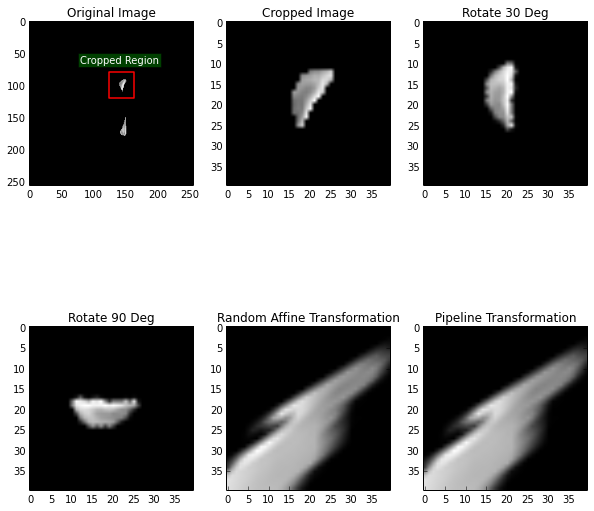

In [11]:
fig = plt.figure(figsize=[10,10])
y = fig.add_subplot(2,3,1)
y.add_patch(plt.Rectangle((start_loc[2]-1,start_loc[1]-1),
                          patch[1],
                          patch[1], fill=False,
                          edgecolor='red', linewidth=1.5)
            )
y.text(start_loc[2]-45, start_loc[1]-15,
       'Cropped Region',
       bbox=dict(facecolor='green', alpha=0.5),
       color='white')
y.imshow(sample[15,:,:,0],cmap='gray')
y.set_title('Original Image')

y = fig.add_subplot(2,3,2)
y.imshow(crop_data[2,:,:,0],cmap='gray')
y.set_title('Cropped Image')

y = fig.add_subplot(2,3,3)
y.imshow(rotate_30_data[2,:,:,0],cmap='gray')
y.set_title('Rotate 30 Deg')

y = fig.add_subplot(2,3,4)
y.imshow(rotate_90_data[2,:,:,0],cmap='gray')
y.set_title('Rotate 90 Deg')

y = fig.add_subplot(2,3,5)
y.imshow(affine_data[2,:,:,0],cmap='gray')
y.set_title('Random Affine Transformation')

y = fig.add_subplot(2,3,6)
y.imshow(pipeline_data[2,:,:,0],cmap='gray')
y.set_title('Pipeline Transformation')